#📦 Instalação das Dependências

In [ ]:
pip install osmnx networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 5.4 MB/s eta 0:00:00


#📚 Importação das Bibliotecas e Configurações do OSMnx

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Configura o OSMnx para usar cache (salva o mapa para não baixar de novo à toa)
ox.settings.use_cache = True
ox.settings.timeout = 180
print("Bibliotecas carregadas e Cache habilitado.")


Bibliotecas carregadas e Cache habilitado.


#📍 Pontos de Interesse (Casa ↔ IFNMG)

In [ ]:

#LOCAIS
locais_personalizados = {
    "CASA GABRIEL": (-16.70125810190415, -43.86099200151538),
    "IFNMG": (-16.68625254941995, -43.82797490933435),
    "PADARIA": (-16.7130, -43.8670),    # Exemplo (ajuste se necessário)
    "POSTO": (-16.7125, -43.8690),      # Exemplo
    "FARMACIA": (-16.7100, -43.8730)    # Exemplo
}

# Define Casa e IFNMG como referência para o tamanho do mapa
casa_coords = locais_personalizados["CASA GABRIEL"]
ifnmg_coords = locais_personalizados["IFNMG"]

print("Coordenadas configuradas com sucesso.")

Coordenadas configuradas com sucesso.


In [ ]:
#ADICIONAR PONTO MANUALMENTE
print("\n--- ADICIONAR NOVO PONTO ---")
while True:
    adicionar = input("Deseja inserir uma coordenada manual? (S/N): ").strip().upper()
    if adicionar != 'S':
        break

    try:
        print("\nEntre com os dados do novo local:")
        novo_nome = input("Nome do Local (ex: MINHA LOJA): ").strip().upper()
        nova_lat = float(input("Latitude (ex: -16.700): "))
        nova_lon = float(input("Longitude (ex: -43.860): "))

        # Adiciona ao dicionário
        locais_personalizados[novo_nome] = (nova_lat, nova_lon)
        print(f"Sucesso! '{novo_nome}' adicionado à lista.")

    except ValueError:
        print("ERRO: Certifique-se de usar PONTO para decimais (ex: -16.5) e não vírgula.")

print(f"\nTotal de locais configurados: {len(locais_personalizados)}")
print("Locais atuais:", list(locais_personalizados.keys()))


--- ADICIONAR NOVO PONTO ---
Deseja inserir uma coordenada manual? (S/N): n

Total de locais configurados: 5
Locais atuais: ['CASA GABRIEL', 'IFNMG', 'PADARIA', 'POSTO', 'FARMACIA']


#🗺️ Cálculo do Centro e Raio para Baixar o Mapa

In [ ]:
print("Calculando área do mapa...")

# Ponto central entre os dois locais principais
center_point = ((casa_coords[0] + ifnmg_coords[0]) / 2,
                (casa_coords[1] + ifnmg_coords[1]) / 2)

# Distância entre eles para definir o zoom do download
dist_meters = ox.distance.great_circle(lat1=casa_coords[0], lon1=casa_coords[1],
                                       lat2=ifnmg_coords[0], lon2=ifnmg_coords[1])

# Margem de segurança de 1km para garantir rotas alternativas
radius_meters = (dist_meters / 2) + 1000

print(f"Distância entre extremos: {dist_meters:.0f}m")
print(f"Baixando área com raio de {radius_meters:.0f}m")

Calculando área do mapa...
Distância entre extremos: 3892m
Baixando área com raio de 2946m


#🌐 Download do Grafo Viário

In [ ]:
# Recalcula o centro baseado na Casa e IFNMG (ou você pode fazer uma média de todos)
casa_coords = locais_personalizados["CASA GABRIEL"]
ifnmg_coords = locais_personalizados.get("IFNMG", casa_coords) # Fallback se não houver IFNMG

center_point = ((casa_coords[0] + ifnmg_coords[0]) / 2, (casa_coords[1] + ifnmg_coords[1]) / 2)

# Distância para o download
dist_meters = ox.distance.great_circle(lat1=casa_coords[0], lon1=casa_coords[1],
                                     lat2=ifnmg_coords[0], lon2=ifnmg_coords[1])
raio_metros = (dist_meters / 2) + 1500  # Margem aumentada para garantir que pontos manuais distantes entrem

print(f"\nBaixando mapa com raio de {raio_metros:.0f}m...")

try:
    G = ox.graph_from_point(center_point, dist=raio_metros, network_type='drive')
    print(f"Mapa baixado com {len(G.nodes())} vértices.")
except Exception as e:
    print(f"Erro ao baixar mapa: {e}")
    G = None


Baixando mapa com raio de 3446m...
Mapa baixado com 4032 vértices.


#🏷️ Mapeamento de Vértices (ID OSM → índice sequencial)

In [ ]:
if G:
    ids_especiais = {}
    labels = {}
    reverse_labels = {}

    print("\nVinculando locais aos vértices da rua mais próxima...")

    for nome, coords in locais_personalizados.items():
        try:
            # Encontra o nó do grafo mais próximo da coordenada digitada
            node_id = ox.distance.nearest_nodes(G, X=coords[1], Y=coords[0])

            ids_especiais[node_id] = nome
            labels[node_id] = nome
            reverse_labels[str(nome)] = node_id
            reverse_labels[str(node_id)] = node_id # Permite buscar pelo ID também

            print(f" -> '{nome}' vinculado ao nó {node_id}")
        except Exception as e:
            print(f"Aviso: '{nome}' está muito longe da área baixada ou erro de coordenada.")

    # Preenche o resto dos nós com números
    node_ids = list(G.nodes())
    for i, node_id in enumerate(node_ids):
        if node_id not in ids_especiais:
            labels[node_id] = i
            reverse_labels[str(i)] = node_id

    print("Mapeamento concluído.")


Vinculando locais aos vértices da rua mais próxima...
 -> 'CASA GABRIEL' vinculado ao nó 2720133195
 -> 'IFNMG' vinculado ao nó 2718048079
 -> 'PADARIA' vinculado ao nó 2730037641
 -> 'POSTO' vinculado ao nó 1399937289
 -> 'FARMACIA' vinculado ao nó 2718315357
Mapeamento concluído.


#🧮 Entrada do Usuário (Escolha dos Vértices)

In [ ]:
# Função para ajudar a ler o input sem erro
def pegar_vertice(mensagem):
    while True:
        entrada = input(mensagem).strip()
        entrada_upper = entrada.upper()

        # Tenta achar pelo NOME ou pelo NÚMERO
        if entrada in reverse_labels:
            return reverse_labels[entrada], entrada
        elif entrada_upper in reverse_labels:
            return reverse_labels[entrada_upper], entrada_upper
        elif str(entrada) in reverse_labels:
            return reverse_labels[str(entrada)], entrada

        print(f"Erro: '{entrada}' não encontrado. Tente um nome da lista ou um número.")

# Mostra opções
print("\n--- NOVA ROTA ---")
print("Opções de locais: " + ", ".join(locais_personalizados.keys()))

# Inputs
origem_id, nome_origem = pegar_vertice("Digite a ORIGEM (ex: CASA GABRIEL): ")
destino_id, nome_destino = pegar_vertice("Digite o DESTINO (ex: IFNMG): ")




--- NOVA ROTA ---
Opções de locais: CASA GABRIEL, IFNMG, PADARIA, POSTO, FARMACIA
Digite a ORIGEM (ex: CASA GABRIEL): CASA GABRIEL
Digite o DESTINO (ex: IFNMG): IFNMG


#🧭 Cálculo da Rota A*

In [ ]:
# Heurística (Distância em linha reta para o A*)
def heuristic(u, v):
    return ox.distance.great_circle(
        lat1=G.nodes[u]['y'], lon1=G.nodes[u]['x'],
        lat2=G.nodes[v]['y'], lon2=G.nodes[v]['x']
    )

print(f"\nCalculando rota A* de {nome_origem} para {nome_destino}...")

path_nodes = None
distancia = 0

try:
    # O Algoritmo A* acontece aqui
    path_nodes = nx.astar_path(G, source=origem_id, target=destino_id,
                               heuristic=heuristic, weight='length')

    # Distância real pela rua
    distancia = nx.shortest_path_length(G, source=origem_id, target=destino_id, weight='length')

    print(f"--- SUCESSO! Distância Total: {distancia:.2f} metros ---")

    caminho_texto = [str(labels[n]) for n in path_nodes]
    print("\nTrajeto Completo: " + " -> ".join(caminho_texto))

except nx.NetworkXNoPath:
    print("ERRO: Não há caminho possível (verifique mãos de rua ou se os pontos estão conectados).")
except Exception as e:
    print(f"Erro no cálculo: {e}")


Calculando rota A* de CASA GABRIEL para IFNMG...
--- SUCESSO! Distância Total: 5022.38 metros ---

Trajeto Completo: CASA GABRIEL -> 2040 -> 2039 -> 2041 -> 221 -> 2033 -> 238 -> 3667 -> 3826 -> 1325 -> 4028 -> 3372 -> 95 -> 3374 -> 93 -> 103 -> 128 -> 228 -> 123 -> 444 -> 2114 -> 46 -> 455 -> 2105 -> 2104 -> 55 -> 3817 -> 2385 -> 2410 -> 460 -> 2387 -> 3877 -> 2332 -> 2330 -> 2374 -> 2375 -> 365 -> 412 -> 1418 -> 353 -> 2100 -> 458 -> 2088 -> 2087 -> 2081 -> 268 -> 302 -> 1730 -> 340 -> 273 -> 334 -> 279 -> 3930 -> 344 -> 324 -> 301 -> 3096 -> 3094 -> 322 -> 2600 -> 336 -> 1593 -> 1594 -> 1685 -> 3678 -> 1683 -> 1682 -> 1675 -> IFNMG


#🗺️ Visualização da Rota no Mapa Real

Gerando imagem do mapa...
Exibindo gráfico...


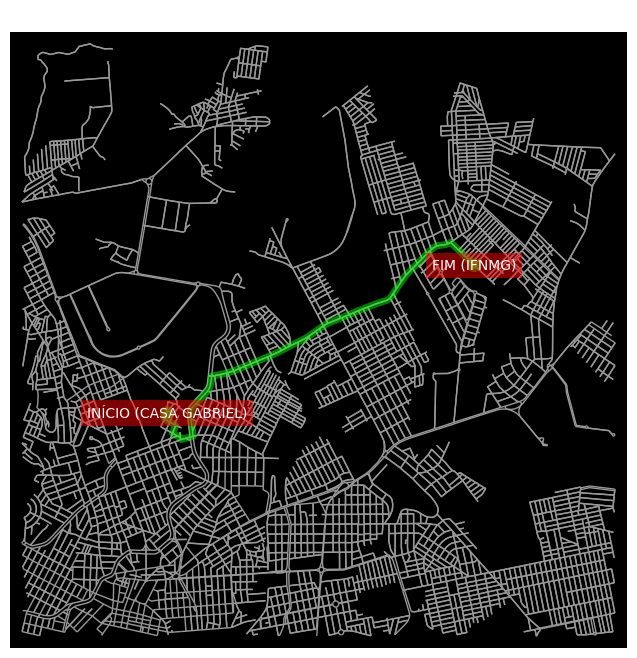

In [ ]:
if 'path_nodes' in locals() and path_nodes is not None:
    print("Gerando imagem do mapa...")

    # Plota o grafo e a rota
    fig, ax = ox.plot_graph_route(G, path_nodes, route_color='lime',
                                  route_linewidth=5, node_size=0, bgcolor='k',
                                  show=False, close=False)

    # Adiciona rótulos de Inicio e Fim no desenho
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    node_labels_map = {
        origem_id: f'INÍCIO ({nome_origem})',
        destino_id: f'FIM ({nome_destino})'
    }

    # Desenha as caixinhas de texto no mapa
    nx.draw_networkx_labels(G, pos, labels=node_labels_map, font_color='white',
                            font_size=10, ax=ax,
                            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none'))

    plt.title(f"Rota: {nome_origem} -> {nome_destino} ({distancia:.0f}m)", color='white', fontsize=12)
    print("Exibindo gráfico...")
    plt.show()
else:
    print("Por favor, rode a Célula 5 primeiro para calcular uma rota válida.")

#🖼️ Visualização Completa do Grafo (Mapa Real + Labels)

Gerando visualização do grafo...


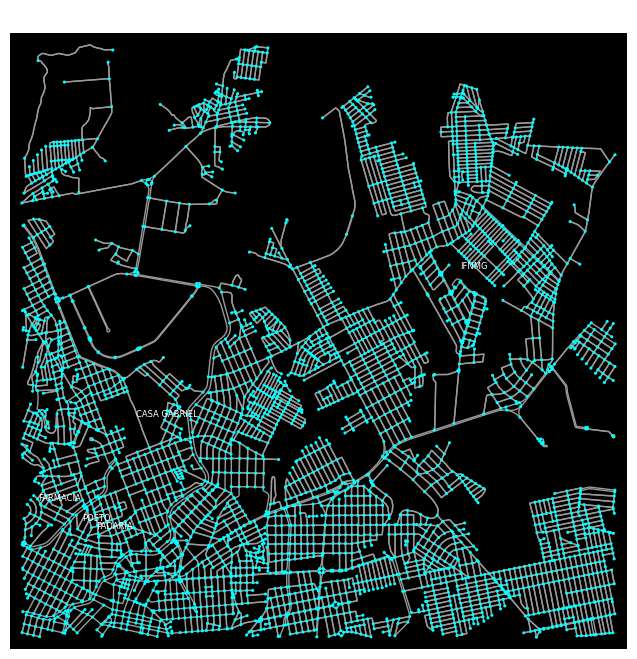

In [ ]:
# Verificação de segurança para garantir que o mapa existe
if 'G' in locals() and G is not None:
    print("Gerando visualização do grafo...")

    # Plota a estrutura base (ruas e esquinas)
    fig, ax = ox.plot_graph(
        G,
        node_size=5,       # Tamanho da bolinha da esquina
        node_color='cyan', # Cor ciano
        edge_linewidth=1,
        edge_color='#999999',
        bgcolor='k',       # Fundo preto
        show=False,
        close=False
    )

    # Pega as posições (latitude/longitude) para colocar os textos
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Desenha os rótulos (Seus nomes personalizados + números)
    if 'labels' in locals():
        labels_apenas_nomes = {k: v for k, v in labels.items() if isinstance(v, str)}
        labels_para_usar = labels_apenas_nomes

        nx.draw_networkx_labels(
            G,
            pos,
            labels=labels_para_usar,
            font_size=6,       # Diminuí um pouco para caber melhor
            font_color='white'
        )

    # Conta os vértices na hora para não dar erro de variável não definida
    qtd_vertices = len(G.nodes())

    ax.set_title(
        f"Grafo Focado: Casa ↔ IFNMG ({qtd_vertices} vértices)",
        fontsize=14,
        color='white'
    )

    plt.show()
else:
    print("Erro: O Grafo (G) não foi carregado. Por favor, rode a Célula 3 primeiro.")

#🔍 Diagrama Esquemático do Grafo (Layout Topológico)

Gerando o diagrama esquemático (pode demorar alguns segundos)...
Exibindo gráfico...


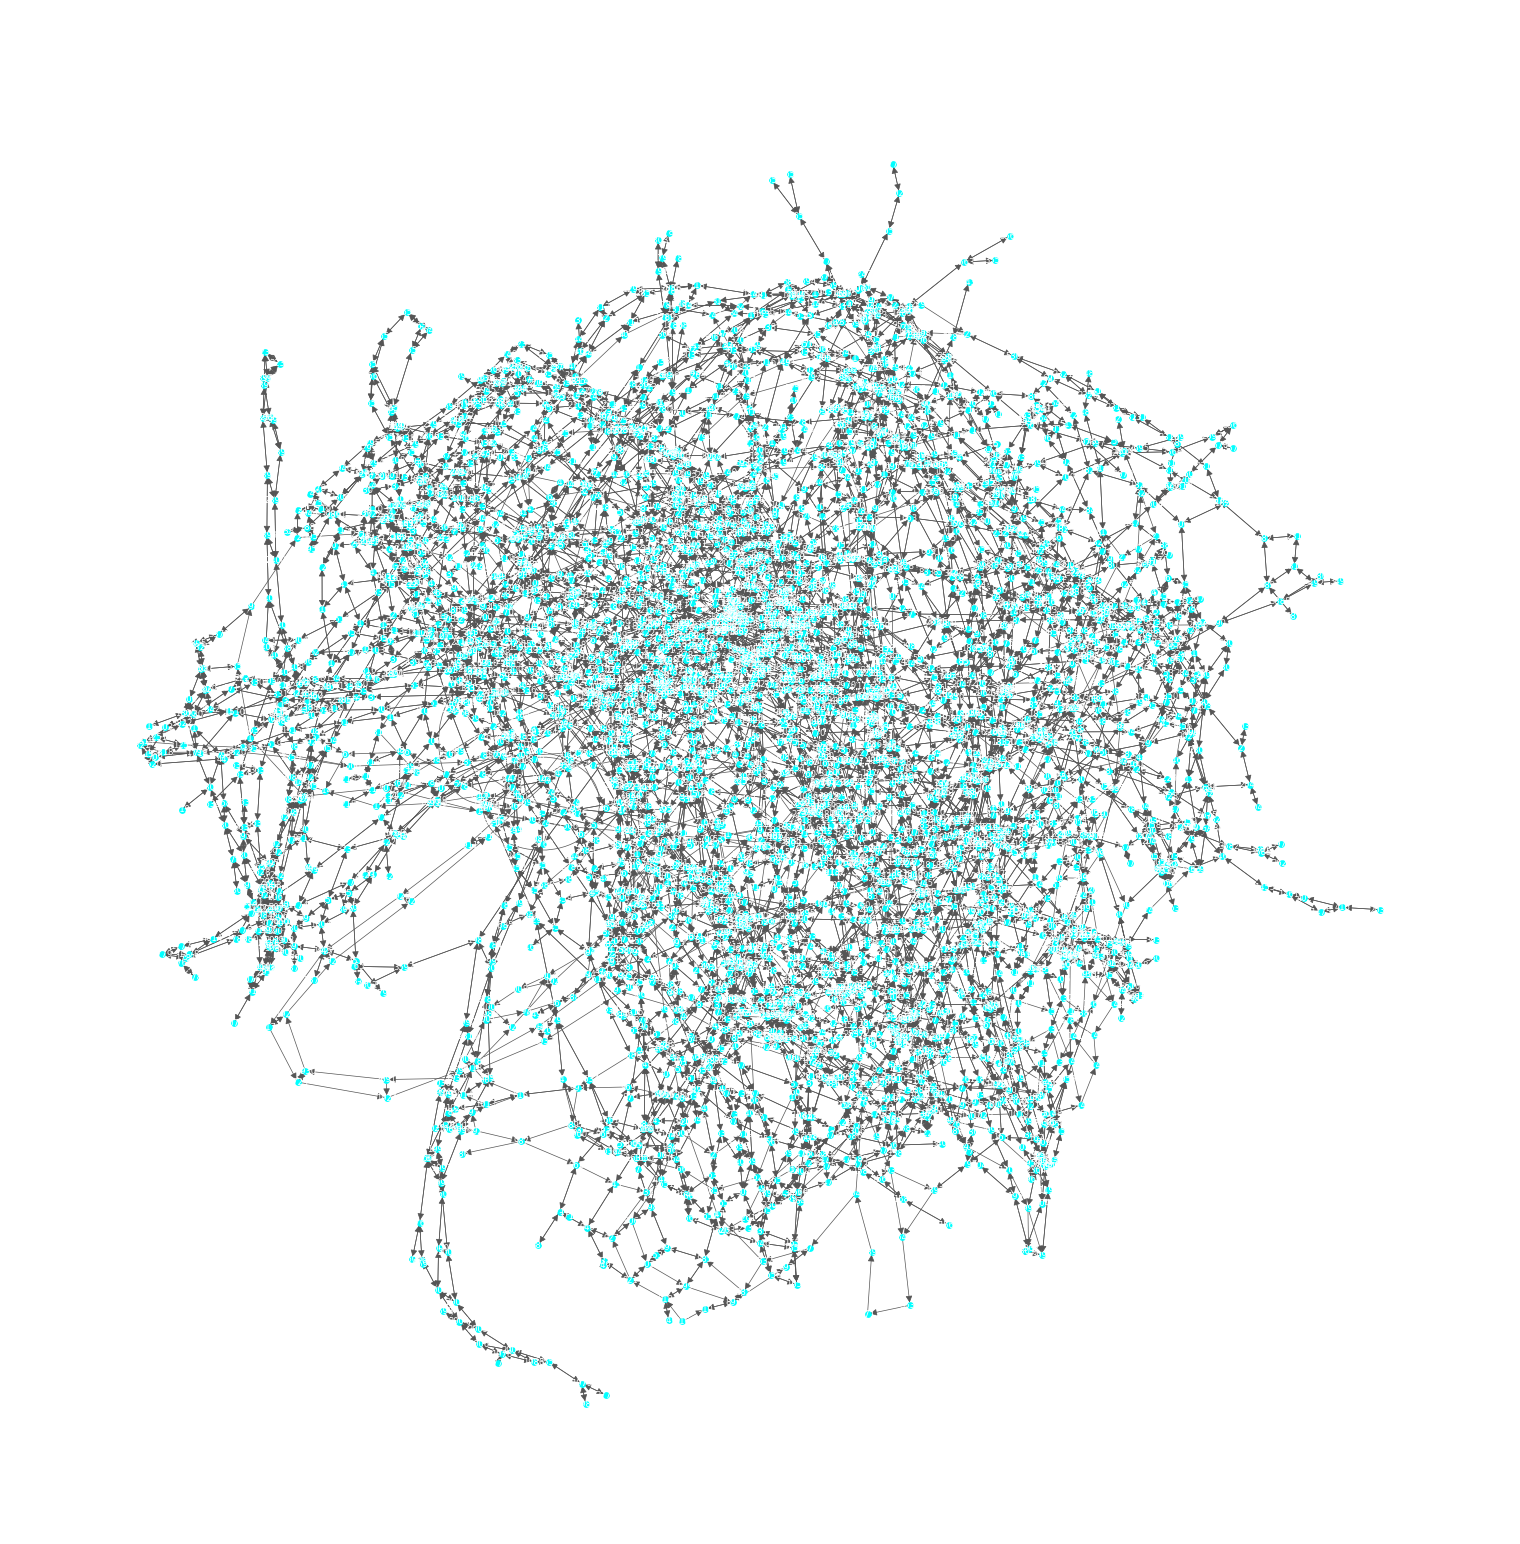

In [ ]:
# Este gráfico ignora a geografia real e organiza os nós para mostrar as conexões (quem liga com quem)

if 'G' in locals() and G is not None:
    print("Gerando o diagrama esquemático (pode demorar alguns segundos)...")

    # Configura o tamanho e cor de fundo
    plt.figure(figsize=(15, 15), facecolor='black')

    # Cria o layout "elástico" (spring).
    # k=0.15 ajuda a separar um pouco mais os nós que k=0.1
    pos_esquema = nx.spring_layout(G, k=0.15, iterations=30, seed=42)

    # Desenha as arestas e nós
    nx.draw(
        G,
        pos=pos_esquema,
        node_size=15,
        node_color='cyan',
        edge_color='#555',
        width=0.5,
        with_labels=False,
        arrows=True,
        arrowstyle='-|>'
    )

    # Desenha os rótulos (Nomes e Números)
    if 'labels' in locals():
        nx.draw_networkx_labels(
            G,
            pos_esquema,
            labels=labels,
            font_size=6,       # Fonte 6 para não poluir muito com nomes longos
            font_color='white'
        )

    # Conta o total de vértices dinamicamente
    qtd_vertices = len(G.nodes())

    plt.title(
        f"Diagrama Esquemático do Grafo ({qtd_vertices} vértices)",
        fontsize=14,
        color='white'
    )

    print("Exibindo gráfico...")
    plt.show()

else:
    print("Erro: O Grafo (G) não foi carregado. Por favor, rode a célula de Download (Célula 3) primeiro.")